# An estimate of total number of infected people 

## Appendix - Time stability

In this notebook, I will repeat the calculations done in the notebook **COVID-19  - An estimate of the total number of infected people** with data taken 5 days ago and I compare them with the results obtained with today's data. 

Since 5 days ago, for some of the countries in main study the number of casualties is very low, I  have decided to just consider the 20 most impacted countries for this appendix

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3.distributions.transforms as tr
import theano.tensor as tt
import scipy
import warnings
import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')


def number_of_infected_people(deaths,populations, p,confidence,steps=350):
    """
    Function to find the number of trials in a binomial distribution at confidence level alpha
    """
    
    nj = []
    
    for death, country_p in zip(deaths,populations):
        j=0
        binomSurvivalDist = 0.0
        n_v = np.logspace(np.log10(death*10),
                          np.log10(country_p),
                          num=steps)
        
        while binomSurvivalDist < confidence:
            if j < steps-1:
                n = n_v[j]
                binomSurvivalDist = scipy.stats.binom.sf(death, n, p)
                j +=1
            else:
                n = n_v[steps-1]
                binomSurvivalDist = confidence + 0.01
            
        nj.append(int(n))
    
    return np.array(nj)


def rate_estimate(x,n_bay_0=0,n_bay_1=0):
    """
    Estimate of the mortality rate using beta function
    """
    rate = scipy.stats.beta.ppf(0.5 , 
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    return rate

def confidence_beta_distribution(x, alpha=0.90, n_bay_0=0,n_bay_1=0):
    """
    Estimate of the confidence intervals of the mortality rate using beta function
    """
    lower = scipy.stats.beta.ppf((1.0 - alpha)/2.0 ,
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    upper = scipy.stats.beta.ppf((1.0 + alpha)/2.0 ,
                                x[0]+n_bay_0+1, 
                               (x[1]+n_bay_1)-(x[0]+n_bay_0)+1)
    return  upper - lower 


def create_df_country(df_world, country_name,n_bay_0=0,n_bay_1=0):
    """
    Create dataframe for country and order by days after first case. 
    """
    df_country = df_world[df_world["countriesAndTerritories"] == country_name]
    #df_country["date_time_date"] = pd.to_datetime(df_country[["year", "month","day"]])
    
    df_country = df_country.sort_values("date_time_date",ascending=True)    
    df_country["Total_cumulative_Cases"] = df_country["cases"].cumsum()
    df_country["Total_cumulative_Deaths"] = df_country["deaths"].cumsum()
    df_country["mortality_rate"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(rate_estimate, axis=1)
    df_country["mortality_error"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(confidence_beta_distribution, axis=1)
    df_country["mortality_relative_error"] = df_country["mortality_error"] / df_country["mortality_rate"]
    df_country["mortality_rate_bayes"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(rate_estimate,
                                                                                                       axis=1,
                                                                                                       n_bay_0=n_bay_0,
                                                                                                       n_bay_1=n_bay_1)
    df_country["mortality_error_bayes"] = df_country[["Total_cumulative_Deaths", "Total_cumulative_Cases"]].apply(confidence_beta_distribution,
                                                                                                        axis=1,
                                                                                                        n_bay_0=n_bay_0,
                                                                                                        n_bay_1=n_bay_1)
    
    df_country = df_country[df_country["Total_cumulative_Cases"]>0]
    first_day = df_country["date_time_date"].iloc[0]
    df_country["number_days"] =  [abs((day - first_day).days) for day in df_country["date_time_date"]]
    
    return df_country

      

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams['figure.figsize'] = [10, 8] #larger plots

In [3]:
df_world_pop = pd.read_csv("our_world_in_data_world_population.csv") #population data from Our World in Data 
df_world_pop_2019 = df_world_pop[df_world_pop["Year"]=="2019"]
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("United States", "United_States_of_America")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("United Kingdom", "United_Kingdom")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("South Korea", "South_Korea")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("United Arab Emirates", "United_Arab_Emirates")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("Saudi Arabia", "Saudi_Arabia")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("Dominican Republic", "Dominican_Republic")
df_world_pop_2019["Entity"] = df_world_pop_2019["Entity"].replace("Czech Republic", "Czechia")

In [4]:
df_world = pd.read_csv("COVID-19-geographic-disbtribution-worldwide-2020-04-30.csv") #cases and causalities from ECPD
df_world = pd.merge(df_world, df_world_pop_2019, left_on = "countriesAndTerritories", right_on= "Entity", how="left") #merging data
df_world["population_per_million"] = np.round(df_world["popData2018"] / 10**6,2)
df_world["date_time_date"] = pd.to_datetime(df_world[["year", "month","day"]])

In [5]:
tests_per_country = pd.read_csv("full-list-total-tests-for-covid-19.csv") #testing data from Our World in Data

tests_per_country["Entity"] = tests_per_country["Entity"].replace("United States", "United_States_of_America")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("United Kingdom", "United_Kingdom")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("South Korea", "South_Korea")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("United Arab Emirates", "United_Arab_Emirates")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("Saudi Arabia", "Saudi_Arabia")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("Dominican Republic", "Dominican_Republic")
tests_per_country["Entity"] = tests_per_country["Entity"].replace("Czech Republic", "Czechia")

tests_per_country["date_time_date"] = [ datetime.datetime.strptime(date, '%b %d, %Y') for date in tests_per_country["Date"].tolist() ]
tests_per_country = tests_per_country.rename(columns={"Entity": "countriesAndTerritories", "B": "c"})

In [6]:
df_world = pd.merge(df_world, tests_per_country, on=['countriesAndTerritories', 'date_time_date'],how="inner") #merging data from EPCD and OWD 

In [7]:
top50_countries = df_world.groupby("countriesAndTerritories").sum().sort_values("cases", ascending=False).reset_index().head(20)["countriesAndTerritories"].tolist()

n_world_top50_cases = df_world[df_world["countriesAndTerritories"].isin(top50_countries)]["cases"].sum()
n_world_top50_death = df_world[df_world["countriesAndTerritories"].isin(top50_countries)]["deaths"].sum()

dict_of_df = {} #dictionary of dataframe, one for each country with data from the 50 most impacted countries

for country in top50_countries:
    
    df = create_df_country(df_world, country, n_bay_0=n_world_top50_death,n_bay_1=n_world_top50_cases)  

    dict_of_df[country] = df   

Let me here retrieve from each country's dataframe the total number of cases, casualties, tests and population for the 50 most impacted countries as of **the last day available (here the 29th of April 2020).**

In [8]:
cases_country = []
pop_country = []
tests_country = []
deaths_country = []

cases_country_1wa = []
pop_country_1wa = []
tests_country_1wa = []
deaths_country_1wa = []


for country in top50_countries:
        
    df = dict_of_df[country]
    cases_country.append(df.iloc[-1]["Total_cumulative_Cases"])
    pop_country.append(df.iloc[-1]["Population"])
    tests_country.append(df.iloc[-1]["Total tests"])
    deaths_country.append(df.iloc[-1]["Total_cumulative_Deaths"])
    
    cases_country_1wa.append(df.iloc[-7]["Total_cumulative_Cases"])
    pop_country_1wa.append(df.iloc[-7]["Population"])
    tests_country_1wa.append(df.iloc[-7]["Total tests"])
    deaths_country_1wa.append(df.iloc[-7]["Total_cumulative_Deaths"])
    
deaths_country = np.array(deaths_country)
cases_country = np.array(cases_country)
pop_country = np.array(pop_country)
tests_country = np.array(tests_country)

deaths_country_1wa = np.array(deaths_country_1wa)
cases_country_1wa = np.array(cases_country_1wa)
pop_country_1wa = np.array(pop_country_1wa)
tests_country_1wa = np.array(tests_country_1wa)


N=len(cases_country)

## Estimating the infection rate with hierarchical Bayesian model

As seen in the previous section, we can estimate the posterior distribution for $\theta^{i}_T$, given the number of tests and observed infected people thanks to a hierarchical Bayesian model, which I will implement here using pymc3. 

As the reader can seen below, it is pretty simple to define the model discussed in the previous sections in pymc3 and generate posterior samples, whose number I fix here to 1000.

In [9]:
def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))


with pm.Model() as infection_model:

    ab_dis = pm.HalfFlat('ab_dis',
                     shape=2)
    
    pm.Potential('p(a, b)_dis', logp_ab(ab_dis))

    X_dis = pm.Deterministic('X_dis', tt.log(ab_dis[0]/ab_dis[1]))
    Z_dis = pm.Deterministic('Z_dis', tt.log(tt.sum(ab_dis)))
            
    theta_dis= pm.Beta('theta_dis', alpha=ab_dis[0], beta=ab_dis[1],shape=N)
    
    n_cases = pm.Binomial('n_cases', n=tests_country, p=theta_dis, observed=cases_country)

    trace_dis = pm.sample(1000, tune=2000, chains=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_dis, ab_dis]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:22<00:00, 266.85draws/s]


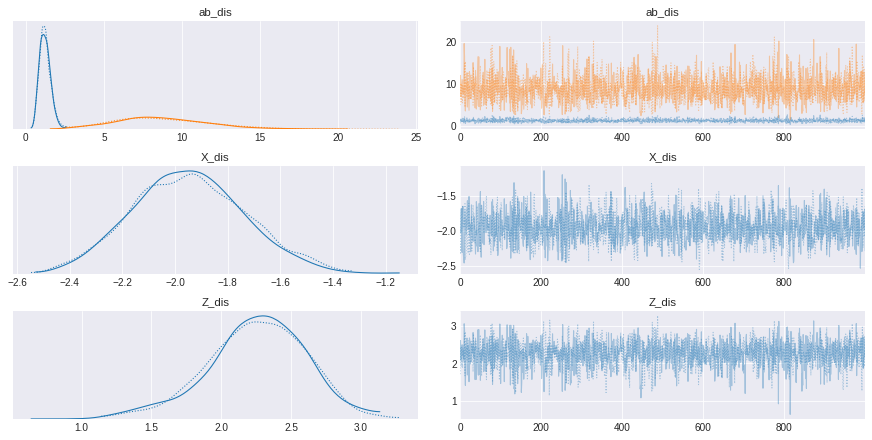

In [10]:
pm.traceplot(trace_dis, var_names=['ab_dis', 'X_dis', 'Z_dis']);

The trace looks pretty good and likelihood maximization has converged, so we can be quite confident about the results obtained for the posterior distribution. 

Let me repeat the calculation with 5 days ago data:

In [11]:
def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))


with pm.Model() as infection_model:

    ab_dis_1wa = pm.HalfFlat('ab_dis_1wa',
                     shape=2)
    
    pm.Potential('p(a, b)_dis_1wa', logp_ab(ab_dis_1wa))

    X_dis_1wa = pm.Deterministic('X_dis_1wa', tt.log(ab_dis_1wa[0]/ab_dis_1wa[1]))
    Z_dis_1wa = pm.Deterministic('Z_dis_1wa', tt.log(tt.sum(ab_dis_1wa)))
            
    theta_dis_1wa = pm.Beta('theta_dis_1wa', alpha=ab_dis_1wa[0], beta=ab_dis_1wa[1],shape=N)
    
    n_cases_1wa = pm.Binomial('n_cases_1wa', n=tests_country_1wa, p=theta_dis_1wa, observed=cases_country_1wa)

    trace_dis_1wa = pm.sample(1000, tune=2000, chains=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_dis_1wa, ab_dis_1wa]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:15<00:00, 387.22draws/s]


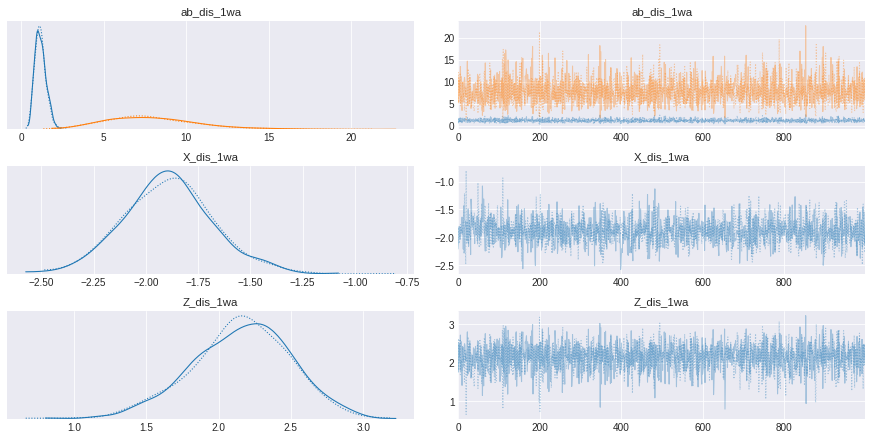

In [12]:
pm.traceplot(trace_dis_1wa, var_names=['ab_dis_1wa', 'X_dis_1wa', 'Z_dis_1wa']);

In [13]:
theta_dis = [scipy.stats.beta.ppf(0.5,a_dis,b_dis) for  a_dis, b_dis in trace_dis['ab_dis']]

theta_dis_1wa = [scipy.stats.beta.ppf(0.5,a_dis_1wa,b_dis_1wa) for  a_dis_1wa, b_dis_1wa in trace_dis_1wa['ab_dis_1wa']]

(0.0, 20.0)

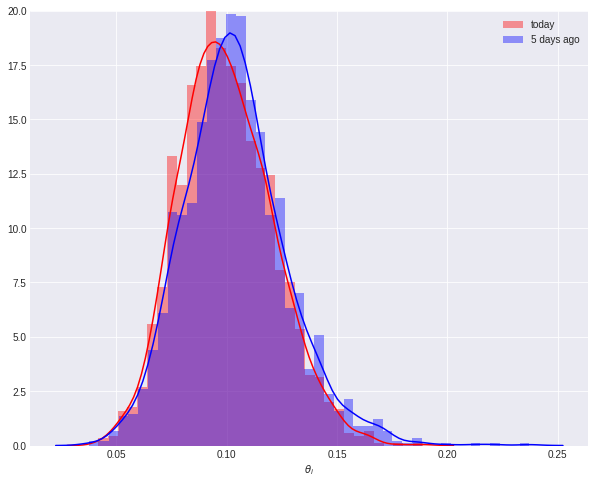

In [14]:
sns.distplot(np.array(theta_dis),color='r',label='today');
sns.distplot(np.array(theta_dis_1wa),color='b',label='5 days ago');
plt.xlabel(r'$\theta_i$');
plt.legend()
plt.ylim(0,20)

From which we conclude that the estimate of $\theta^{i}_T$ is pretty stable in the period considered.

## Estimate of the fatality rate

We can use the same technique to estimate the time stability of $\theta^{f}_T$.

In [15]:
def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))


with pm.Model() as infection_model:

    ab_mort = pm.HalfFlat('ab_mort',
                     shape=2)
    
    pm.Potential('p(a, b)_mort', logp_ab(ab_mort))

    X_mort = pm.Deterministic('X_mort', tt.log(ab_mort[0]/ab_mort[1]))
    Z_mort = pm.Deterministic('Z_mort', tt.log(tt.sum(ab_mort)))
    
    theta_mort= pm.Beta('theta_mort', alpha=ab_mort[0], beta=ab_mort[1],shape=N)
    
    n_deaths = pm.Binomial('n_deaths', n=cases_country, p=theta_mort, observed=deaths_country)
    
    
    trace_mort = pm.sample(1000, tune=2000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_mort, ab_mort]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:07<00:00, 829.49draws/s] 


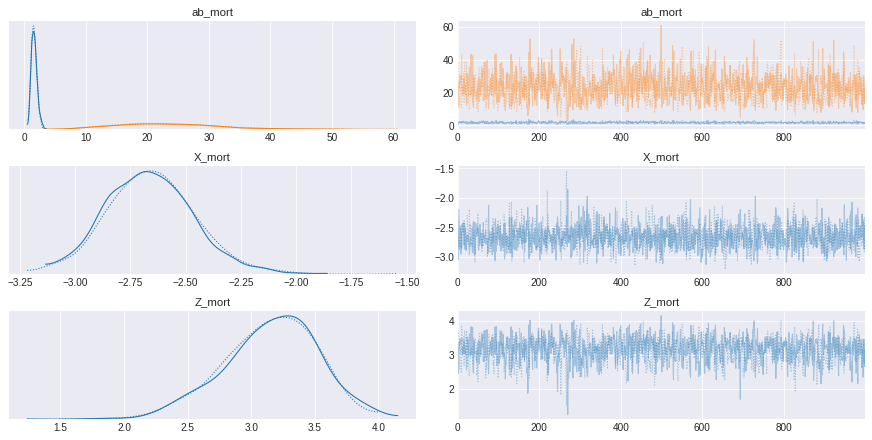

In [16]:
pm.traceplot(trace_mort, var_names=['ab_mort', 'X_mort', 'Z_mort']);

In [17]:
def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))


with pm.Model() as infection_model:

    ab_mort_1wa = pm.HalfFlat('ab_mort_1wa',
                     shape=2)
    
    pm.Potential('p(a, b)_mort_1wa', logp_ab(ab_mort_1wa))

    X_mort_1wa = pm.Deterministic('X_mort_1wa', tt.log(ab_mort_1wa[0]/ab_mort_1wa[1]))
    Z_mort_1wa = pm.Deterministic('Z_mort_1wa', tt.log(tt.sum(ab_mort_1wa)))
            
    theta_mort_1wa = pm.Beta('theta_mort_1wa', alpha=ab_mort_1wa[0], beta=ab_mort_1wa[1],shape=N)
    
    n_cases_1wa = pm.Binomial('n_cases_1wa', n=tests_country_1wa, p=theta_mort_1wa, observed=cases_country_1wa)

    trace_mort_1wa = pm.sample(1000, tune=2000, chains=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_mort_1wa, ab_mort_1wa]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:21<00:00, 282.31draws/s]


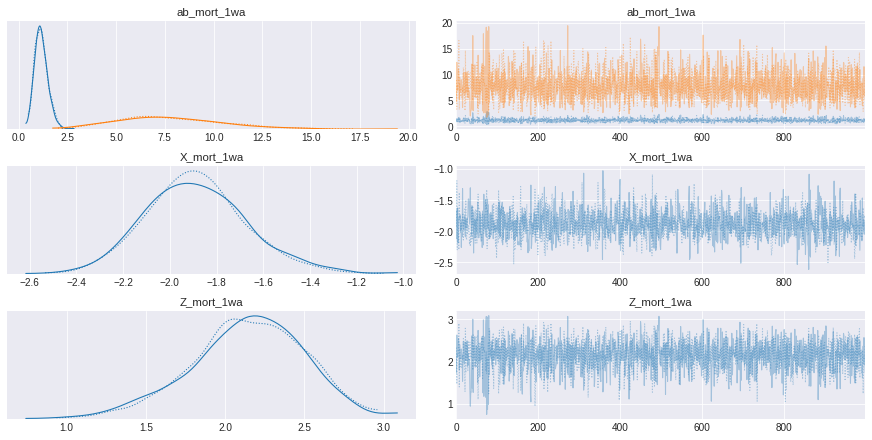

In [18]:
pm.traceplot(trace_mort_1wa, var_names=['ab_mort_1wa', 'X_mort_1wa', 'Z_mort_1wa']);

In [19]:
theta_mort = [scipy.stats.beta.ppf(0.5,a_mort,b_mort) for  a_mort, b_mort in trace_mort['ab_mort']]

theta_mort_1wa = [scipy.stats.beta.ppf(0.5,a_mort_1wa,b_mort_1wa) for  a_mort_1wa, b_mort_1wa in trace_mort_1wa['ab_mort_1wa']]

Text(0.5, 0, '$\\theta_m$')

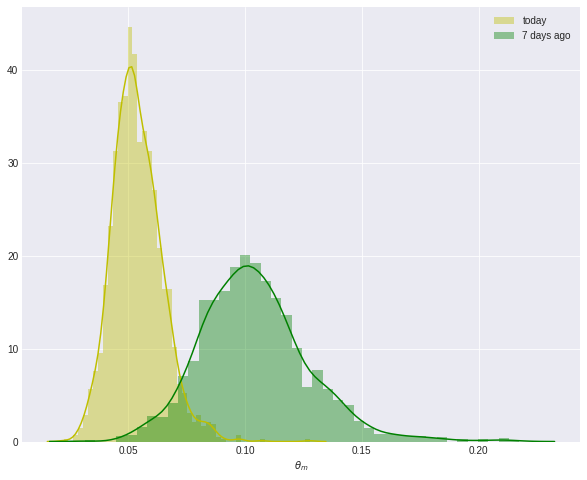

In [34]:
sns.distplot(np.array(theta_mort),color='y',label='today');
sns.distplot(np.array(theta_mort_1wa),color='g',label='7 days ago');

plt.legend()
plt.xlabel(r'$\theta_m$')

From we see that the estimate of the fatality rate changed substantially over the last 7 days. This is mostly due to the fact that for most of the countries in the study the number of casualties is still growing very fast while the number of infected people is growing at a lower pace.

In [21]:
theta_tot_elements = [scipy.stats.beta.ppf(0.5,a_dis,b_dis)*scipy.stats.beta.ppf(0.5,a_mort,b_mort) for a_dis,  b_dis, a_mort, b_mort in list(zip(trace_dis['ab_dis'][:,0],trace_dis['ab_dis'][:,1],trace_mort['ab_mort'][:,0],trace_mort['ab_mort'][:,1]))]

In [22]:
theta_tot_elements_1wa = [scipy.stats.beta.ppf(0.5,a_dis_1wa,b_dis_1wa)*scipy.stats.beta.ppf(0.5,a_mort_1wa,b_mort_1wa) for a_dis_1wa,  b_dis_1wa, a_mort_1wa, b_mort_1wa in list(zip(trace_dis_1wa['ab_dis_1wa'][:,0],trace_dis_1wa['ab_dis_1wa'][:,1],trace_mort_1wa['ab_mort_1wa'][:,0],trace_mort_1wa['ab_mort_1wa'][:,1]))]

Text(0.5, 0, '$\\theta_t$')

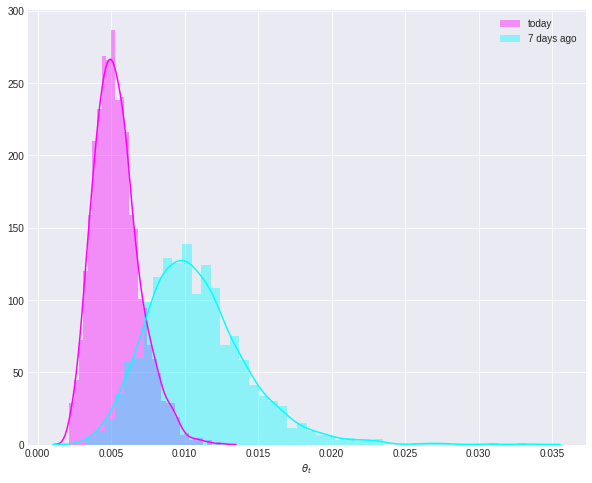

In [35]:
sns.distplot(np.array(theta_tot_elements),color='magenta',label='today');
sns.distplot(np.array(theta_tot_elements_1wa),color='cyan',label='7 days ago');

plt.legend()
plt.xlabel(r'$\theta_t$')

In [24]:
theta_tot = np.percentile(theta_tot_elements,50)
theta_tot_low = np.percentile(theta_tot_elements,5)
theta_tot_upper = np.percentile(theta_tot_elements,95)

In [25]:
theta_tot_1wa = np.percentile(theta_tot_elements_1wa,50)
theta_tot_low_1wa = np.percentile(theta_tot_elements_1wa,5)
theta_tot_upper_1wa = np.percentile(theta_tot_elements_1wa,95)

where we can see the effect of the change in the fatality rate into the the general fatality rate $\theta^{f}_T$

## Estimating the total number of infections for COVID-19 - Time stability

Just repeating the same calculation of the previous notebook with data taken with 5 days ago.

In [26]:
true_cases = number_of_infected_people(deaths_country,pop_country,theta_tot,0.9)
true_cases_up = number_of_infected_people(deaths_country,pop_country,theta_tot_low,0.9)
true_cases_low = number_of_infected_people(deaths_country,pop_country,theta_tot_upper,0.9)

In [27]:
true_cases_1wa = number_of_infected_people(deaths_country_1wa,pop_country_1wa,theta_tot_1wa,0.9)
true_cases_up_1wa = number_of_infected_people(deaths_country_1wa,pop_country_1wa,theta_tot_low_1wa,0.9)
true_cases_low_1wa = number_of_infected_people(deaths_country_1wa,pop_country_1wa,theta_tot_upper_1wa,0.9)

That can used to compute the estimate of the percentage of total population that has been infected for each country: 

In [28]:
perc_contaged_country = true_cases / pop_country 
lower_bound_perc_contaged_country = (true_cases - true_cases_low) / pop_country
upper_bound_perc_contaged_country = (true_cases_up - true_cases)  / pop_country

In [29]:
perc_contaged_country_1wa = true_cases_1wa / pop_country_1wa 
lower_bound_perc_contaged_country_1wa = (true_cases_1wa - true_cases_low_1wa) / pop_country_1wa
upper_bound_perc_contaged_country_1wa = (true_cases_up_1wa - true_cases_1wa)  / pop_country_1wa

And also to estimate the ratio between the total number of infected people and the observed number of infected people:

In [30]:
ratio_true_cases_cases = true_cases / cases_country
lower_bound_ratio_true_cases_cases = (true_cases - true_cases_low) /  cases_country
upper_bound_ratio_true_cases_cases = (true_cases_up - true_cases) /  cases_country

In [31]:
ratio_true_cases_cases_1wa = true_cases_1wa / cases_country_1wa
lower_bound_ratio_true_cases_cases_1wa = (true_cases_1wa - true_cases_low_1wa) /  cases_country_1wa
upper_bound_ratio_true_cases_cases_1wa = (true_cases_up_1wa - true_cases_1wa) /  cases_country_1wa

## Analysis of the results

Let me start by plotting the ratio between the estimated total number of infected people and the observed cases five days ago against the estimated total number of infected people and the observed cases.

Text(0, 0.5, 'Total cases / Cases')

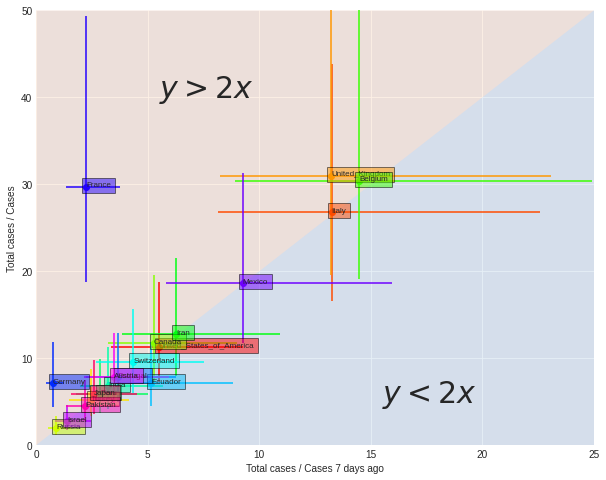

In [37]:
cmap = plt.cm.get_cmap("hsv", len(top50_countries)+1)


from random import shuffle

x = np.arange(0,10) # just a straight line 

for country, j in zip(top50_countries,range(len(top50_countries))):
         
    plt.errorbar(ratio_true_cases_cases_1wa[j], 
                 ratio_true_cases_cases[j],
             linestyle = ' ',
             marker = 'o',
             yerr = [[lower_bound_ratio_true_cases_cases[j]],
                     [upper_bound_ratio_true_cases_cases[j]]],
             xerr = [[lower_bound_ratio_true_cases_cases_1wa[j]],
                     [upper_bound_ratio_true_cases_cases_1wa[j]]],
             label = country,
             color = cmap(j) )
    
    plt.text(ratio_true_cases_cases_1wa[j], 
                 ratio_true_cases_cases[j],
            s=country,
            fontsize=8,
            bbox=dict(facecolor=cmap(j), alpha=0.5),
            rotation=0)


plt.text(15.5,5,s=r"$y<2x$",fontsize=30)
plt.text(5.5,40,s=r"$y>2x$",fontsize=30)


x = np.arange(0,100) # just a straight line 
plt.fill_between(x,2*x,np.zeros(len(x)),alpha = 0.1)
plt.fill_between(x,2*x,50*np.ones(len(x)),alpha = 0.1)
plt.ylim(0,50)
plt.xlim(0,25)
plt.xlabel("Total cases / Cases 7 days ago")
plt.ylabel("Total cases / Cases")

From which we can see that for most of the countries, the ratio between the estimated total number of infected people and the observed cases **almost doubled in the last 7 days.**

A noticible outsider is France, for which the ratio between the estimated total number of infected people and the observed cases became **almost 10 times higher in the last 7 days due to the very fast growth of the number of casualties during the last week.**

(0.0, 0.18)

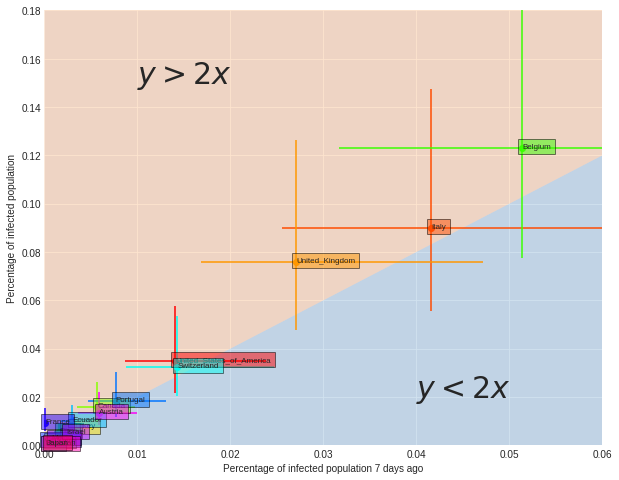

In [38]:
cmap = plt.cm.get_cmap("hsv", len(top50_countries)+1)


from random import shuffle

x = np.arange(0,10) # just a straight line 

for country, j in zip(top50_countries,range(len(top50_countries))):
         
    plt.errorbar(perc_contaged_country_1wa[j], 
                 perc_contaged_country[j],
             linestyle = ' ',
             marker = 'o',
             yerr = [[lower_bound_perc_contaged_country[j]],
                     [upper_bound_perc_contaged_country[j]]],
             xerr = [[lower_bound_perc_contaged_country_1wa[j]],
                     [upper_bound_perc_contaged_country_1wa[j]]],
             label = country,
             color = cmap(j) )
    
    plt.text(perc_contaged_country_1wa[j], 
                 perc_contaged_country[j],
            s=country,
            fontsize=8,
            bbox=dict(facecolor=cmap(j), alpha=0.5),
            rotation=0)

    
plt.text(0.04,0.02,s=r"$y<2x$",fontsize=30)
plt.text(0.01,0.15,s=r"$y>2x$",fontsize=30)

x = np.linspace(0,0.1) # just a straight line 
plt.fill_between(x,2*x,np.zeros(len(x)),alpha = 0.2)
plt.fill_between(x,2*x,0.2*np.ones(len(x)),alpha = 0.2)
plt.ylabel("Percentage of infected population")
plt.xlabel("Percentage of infected population 7 days ago")
plt.xlim(0., 0.06)
plt.ylim(0., 0.18)

A similar result can be found for the estimated percentage of infected population, **which more doubled in the last 7 days**  